In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.core.debugger import Tracer
from six.moves import cPickle 

# Fetch data with the following
#
#   wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#   tar xzf cifar-10-python.tar.gz
# 

def load_batch(path):
    # https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib
    f = open(path, 'rb')
    datadict = cPickle.load(f,encoding='latin1')
    f.close()
    X = datadict["data"] 
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32")
    X = X.reshape(10000, -1)
    Y = np.array(Y)
    return X, Y

im_batches = []
all_labels = []
for i in [1,2,3,4,5]:
    ims, labs = load_batch('/home/nbuser/cifar-10-batches-py/data_batch_%s' % i)
    im_batches.append(ims)
    all_labels.append(labs)
    
all_raw_images = np.vstack(im_batches)
all_labels = np.hstack(all_labels)


In [2]:
label_names = [    
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]
#Visualizing CIFAR 10

def show_images(images):
    # TODO: Add flag to unwhiten?
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(images)))
            axes1[j][k].set_axis_off()
            data = images[i:i+1][0].reshape(32, 32, 3).astype('uint8')
            axes1[j][k].imshow(data)
                
    plt.show()

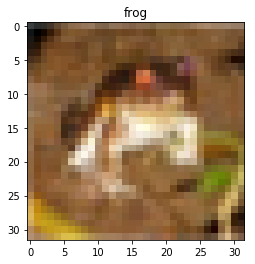

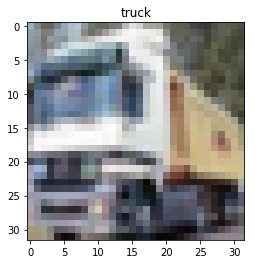

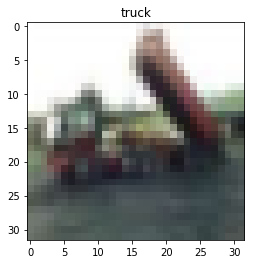

In [3]:
for i in range(3):
    img = all_raw_images[i].reshape(32, 32, 3).astype('uint8')
    plt.imshow(img)
    plt.title(label_names[all_labels[i]])
    plt.show()

In [4]:
print(len(all_raw_images))

TRAINING_MEAN = np.mean(all_raw_images)
TRAINING_STD = np.std(all_raw_images)

def whiten(images):
    images = images - TRAINING_MEAN
    return images / TRAINING_STD
    
def unwhiten(images):
    images = images * TRAINING_STD
    return images + TRAINING_MEAN
    
images = whiten(all_raw_images)[:45000]
labels = all_labels[:45000]

val_images = whiten(all_raw_images)[45000:]
val_labels = all_labels[45000:]

all_raw_test_images, test_labels = load_batch('/home/nbuser/cifar-10-batches-py/test_batch')
test_images = whiten(all_raw_test_images)
test_labels = np.asarray(test_labels)

50000


-0.269062 0.81019


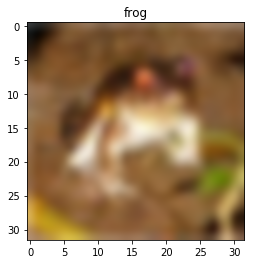

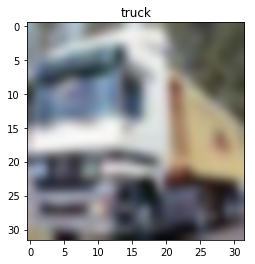

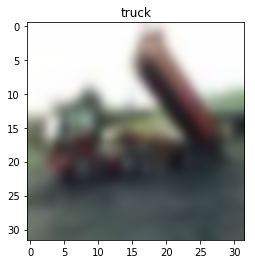

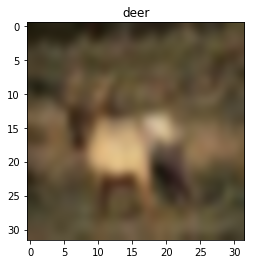

In [5]:
print(np.mean(images[0]), np.std(images[0]))

def show_whitened_image(image, label=None):
    image = unwhiten(image)
    image = image.reshape(32, 32, 3).astype("uint8")
    plt.imshow(image, interpolation="bicubic")
    if label:
        plt.title(label_names[label])
    plt.show()

for i in range(4):
    show_whitened_image(images[i], labels[i])

Raw
120.708
4115.23
Whitened
1.49569e-05
1.00126


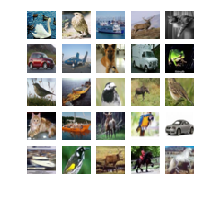

In [6]:
print("Raw")
print(np.mean(all_raw_images))
print(np.var(all_raw_images))

print("Whitened")
print(np.mean(images))
print(np.var(images))

show_images(unwhiten(images))

Whitened Test
0.0128064
0.997227


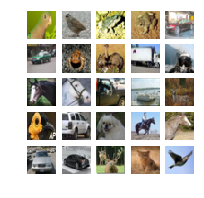

10000


In [7]:
print("Whitened Test")
print(np.mean(test_images))
print(np.var(test_images))

show_images(unwhiten(test_images))
print(len(test_images))

In [8]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

1.1.0
['/gpu:0']


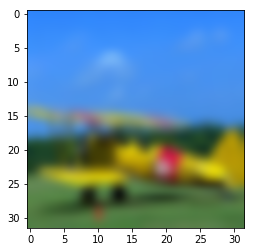

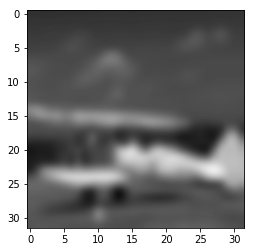

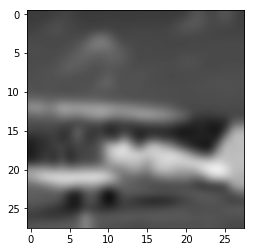

In [44]:
# Test dirac

im_flat = unwhiten(test_images[44])

im = im_flat.reshape(32, 32, 3)

plt.imshow(im.astype("uint8"), interpolation="bicubic")
plt.show()


im_chan = im[:,:,0]
plt.imshow(im_chan, interpolation="bicubic", cmap='gray')
plt.show()

sess = tf.InteractiveSession()

reshaped_im_chan = im_chan[None,:]
reshaped_im_chan = np.expand_dims(reshaped_im_chan, -1)
im_tensor = tf.constant(reshaped_im_chan)

W = np.zeros([5, 5, 1, 1])
W[3,3,0,0] = 1.
dirac_conv = tf.nn.conv2d(im_tensor, W, strides=[1,1,1,1], padding='VALID')


convolved = dirac_conv.eval()

plt.imshow(convolved[0,:,:,0], interpolation="bicubic", cmap='gray')
plt.show()

In [9]:
# Set the seed for determinism
tf.reset_default_graph()
tf.set_random_seed(1)

# Build our models
input_size = 3*32*32
output_size = 10
batch_size = 50 # To use GPU correctly

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    """Use this to halve the size after a conv"""
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def weight_var(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_var(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, shape=(None, input_size))
    y_train = tf.placeholder(tf.int32, shape=(batch_size))

    # Conv weights
    W_conv1 = weight_var([5, 5, 3, 32])
    b1 = bias_var([32])
                
    W_conv2 =  weight_var([5, 5, 32, 64])
    b2 = bias_var([64])
    
    # Conv layers
    x_image = tf.reshape(x, [-1, 32, 32, 3]) # TODO: Is this correctly unwrapped?
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b1) # (28x28x32)
    h_pool1 = max_pool_2x2(h_conv1) # (16x16x32)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b2) # (16x16x64)
    h_pool2 = max_pool_2x2(h_conv2) # (8x8x64)
    
    h_pool2_size = 8*8*64
    h_pool2_flat = tf.reshape(h_pool2, [-1, h_pool2_size])
    
    
    # FC weights
    W3 = weight_var([h_pool2_size, 1024])
    b3 = bias_var([1024])

    W4 = weight_var([1024, output_size])
    b4 = bias_var([output_size])
    
    # FC layers    
    h_fc = tf.nn.relu(tf.matmul(h_pool2_flat, W3) + b3)    

    keep_prob = tf.placeholder(tf.float32)
    h_fc_drop = tf.nn.dropout(h_fc, keep_prob)

    logits = tf.matmul(h_fc_drop, W4) + b4
    
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    # Optimizers
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    # global_step = tf.Variable(0, trainable=False, name="global_step")
    # train_op = optimizer.minimize(loss, global_step=global_step)
    train_op = optimizer.minimize(loss)

sess = tf.InteractiveSession()

In [111]:
def check_accuracy(test_ims, test_ys):    
    total_correct = 0
    for i in range(len(test_ims) // batch_size):
        logits_out = sess.run(logits, feed_dict={
            x: test_ims[i*batch_size:(i+1)*batch_size],
            keep_prob: 1.0
        })

        y_pred = np.argmax(logits_out, 1)
        correct = (y_pred - test_ys[i*batch_size:(i+1)*batch_size]) == 0
        total_correct += correct

    acc = np.sum(total_correct) / len(test_ys)

    message = "%s correct out of %s => accuracy: %s" % ( np.sum(total_correct), len(test_ys), acc)
    return acc, message

In [112]:
report = {
    'loss': [],
    'val_acc': [],
}

def sample(images, labels, n=50):
    sample_indices = random.sample(range(len(images)), n)
    return images[sample_indices], labels[sample_indices]

n_epochs = 20

# Clear out the session
sess.run(tf.global_variables_initializer())
for i in range(n_epochs*1000+1):
    # Train with a minibatch

    train_ims, train_labels = sample(images, labels)
    _, l = sess.run([train_op, loss], feed_dict={
        x: train_ims,
        y_train: train_labels,
        keep_prob: 0.5,
    })

    if i % 50 == 0:
        report['loss'].append(l)
        acc, acc_msg = check_accuracy(*sample(val_images, val_labels, 1000))

        report['val_acc'].append(acc)
        
        
    if i % 200 == 0:
        print("\nIteration: %s loss: %s" % (i, l))
        print(acc_msg)


Iteration: 0 loss: 28.6224
91 correct out of 1000 => accuracy: 0.091

Iteration: 200 loss: 1.96981
365 correct out of 1000 => accuracy: 0.365

Iteration: 400 loss: 1.61193
394 correct out of 1000 => accuracy: 0.394

Iteration: 600 loss: 1.69157
452 correct out of 1000 => accuracy: 0.452

Iteration: 800 loss: 1.48432
456 correct out of 1000 => accuracy: 0.456

Iteration: 1000 loss: 1.21387
521 correct out of 1000 => accuracy: 0.521

Iteration: 1200 loss: 1.71834
528 correct out of 1000 => accuracy: 0.528

Iteration: 1400 loss: 1.08028
530 correct out of 1000 => accuracy: 0.53

Iteration: 1600 loss: 1.10225
563 correct out of 1000 => accuracy: 0.563

Iteration: 1800 loss: 0.978958
583 correct out of 1000 => accuracy: 0.583

Iteration: 2000 loss: 1.00222
619 correct out of 1000 => accuracy: 0.619

Iteration: 2200 loss: 1.10166
583 correct out of 1000 => accuracy: 0.583

Iteration: 2400 loss: 1.03387
618 correct out of 1000 => accuracy: 0.618

Iteration: 2600 loss: 1.08336
642 correct out

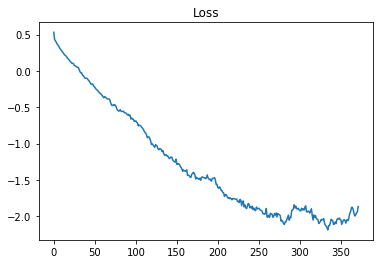

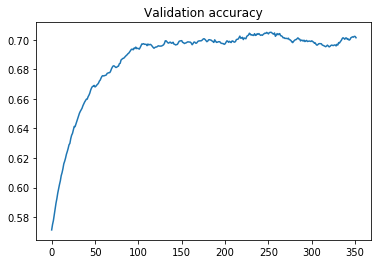

Final validation accuracy: 69.9%
Final test accuracy: 69.2%


In [113]:
def smooth(vals):
    window = 30    
    return np.convolve(vals, np.ones(window)/window, mode='valid')

plt.plot(smooth(np.log(report['loss'])))
plt.title("Loss")
plt.show()

plt.title("Validation accuracy")
ys = smooth(report['val_acc'][20:])
plt.plot(ys)
plt.show()

print("Final validation accuracy: %.1f%%" % (np.mean(report['val_acc'][-10:]) *100))

acc, _ = check_accuracy(test_images, test_labels)
print("Final test accuracy: %.1f%%" % (acc*100))

In [96]:
# Render misclassified data
test_ims = test_images
test_ys = test_labels

total_correct = 0
wrongs = []
for i in range(len(test_ims) // batch_size):
    logits_out = sess.run(logits, feed_dict={
        x: test_ims[i*batch_size:(i+1)*batch_size],
        keep_prob: 1.
    })
    
    y_pred = np.argmax(logits_out, 1)
    incorrect_idxs, = np.where((y_pred - test_ys[i*batch_size:(i+1)*batch_size]) != 0)
    wrongs = np.concatenate([wrongs, incorrect_idxs + batch_size*i])

In [ ]:
print("Showing broken images")
for idx in range(100):
# for idx in wrongs[10:20]:
    im = test_ims[int(idx)]
    logits_out = sess.run(logits, feed_dict={
        x: [im],
        keep_prob: 1.
    })

    show_whitened_image(im)
    plt.title("pred: %s   actual: %s" % (label_names[np.argmax(logits_out, 1)], 
                                         label_names[test_labels[int(idx)]]
                                        ))
